<a href="https://colab.research.google.com/github/aireslucas/MachineLearning/blob/main/Multiclass_pt1_Lucas_Aires_v1_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Part I (C)

Lucas Aires da Costa Silva

In this notebook, we used the Flower dataset, for multiclass study, changing the learning rate (lr), after using on part B, the Learning Rate Finder
 We saw that the new learning rate was not that good, meaning we could have some implementation error



>The dataset was created by

    Tung, KC (2020), “Flower Images jpg”, Mendeley Data, V1, doi: 10.17632/738sdjm6h9.1

 and can be found in Kaggle: [Flowers Multiclass Datasets](https://www.kaggle.com/datasets/alsaniipe/flowers-multiclass-datasets).

>The dataset is licensed as Creative Commons (CC BY 4.0). No changes were made to the dataset.

> We based this work in the book "Deep Learning with PyTorch Step-by-Step: A Beginner's Guide" by Daniel Voigt Godoy

#Imports

In [1]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')


## Architecture class

In [2]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Data Preparation

In [3]:
import kagglehub

path = kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-multiclass-datasets


In [4]:
# Path to dataset
dataset_path = f'{path}/flowers/flowers/flower_photos/train/'

# Classes list (folders)
flower_classes = os.listdir(dataset_path)

# Size of plots
num_classes = len(flower_classes)


## ImageFolder

- Exemple with the training folder

In [5]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize((28,28)),                        # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'flower_photos/train' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root=f'{path}/flowers/flowers/flower_photos/train/',
    transform=temp_transform          # Apply the preprocessing pipeline to every image
)

In [6]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 3540 images
Number of classes: 5


## Standardization

In [7]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [8]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 6.5504,  6.4545,  5.2906],
        [ 3.2637,  3.0717,  3.4697]])

In [9]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[3540.0000, 3540.0000, 3540.0000],
        [1652.0726, 1503.0735, 1072.5658],
        [ 758.1317,  666.2601,  689.4409]])

In [10]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.4667), tensor(0.4246), tensor(0.3030)], std=[tensor(0.2142), tensor(0.1882), tensor(0.1948)], inplace=False)

> Remember that PyTorch converts the pixel values into the [0, 1] range. The average mean value of a pixel for the red (first) channel is 0.4667, while its average standard deviation is 0.2142.

>> **IMPORTANT**: Always use the training set to compute statistics
for standardization! This avoid data leakage!!!

## The Dataset

In [11]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize((28,28)),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])


# Instantiate training and validation datasets from folders:
# - 'rps' contains subfolders per class for training
# - 'rps-test-set' likewise for validation
train_data = ImageFolder(root=f'{path}/flowers/flowers/flower_photos/train/', transform=composer)
val_data   = ImageFolder(root=f'{path}/flowers/flowers/flower_photos/validation/', transform=composer)
test_data = ImageFolder(root=f'{path}/flowers/flowers/flower_photos/test/', transform=composer)

comb_data = val_data + test_data

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(comb_data,   batch_size=16)  # no shuffle for validation

In [12]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

# Dropout

In [13]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [14]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [15]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

In [16]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

In [17]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [18]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [19]:
torch.manual_seed(17)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                         weight=torch.ones(11), bias=torch.tensor(0))
                                for _ in range(1000)])

# Fancier Model

Let’s leave the Sequential model aside for now and build a model class again. This
time, our constructor method will take two arguments: ``n_filters`` and ``p``. We’ll use
``n_filters`` as the number of output channels for both convolutional blocks of our
model (yes, there are two now!). And, as you can see from the code below, we’ll use
``p`` as the probability of **dropout**.

In [20]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 5) # (50, x) to model with x classes
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

The configuration part is short and straightforward:
- We create a model,
- a loss function,
- and an optimizer.

We changed here the learning rate to lr=6e-3.
Which is an approximate value that we found on LRFinder, on part B, of this work.

The model will be an instance of our CNN2 class with five filters and a dropout
probability of 30%.

We are using three filters to perform comparison measurements.

Our dataset has five classes, so we’re using
``nn.CrossEntropyLoss()`` (which will take the three logits produced by our model).

In [21]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=5.98e-3)

> Adaptive moment estimation (Adam) uses adaptive learning
rates, computing a learning rate for each parameter. Yes, you
read it right: Each parameter has a learning rate to call its own!


> If you dig into the state_dict() of an Adam optimizer, you’ll find
tensors shaped like the parameters of every layer in your model
that Adam will use to compute the corresponding learning rates.
True story!

## Model Training and Metrics

In [22]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

In [23]:
print(f"Number of elements: {arch_cnn2.count_parameters()}")

Number of elements: 6925


Text(0.5, 1.0, 'Model with 5 Features')

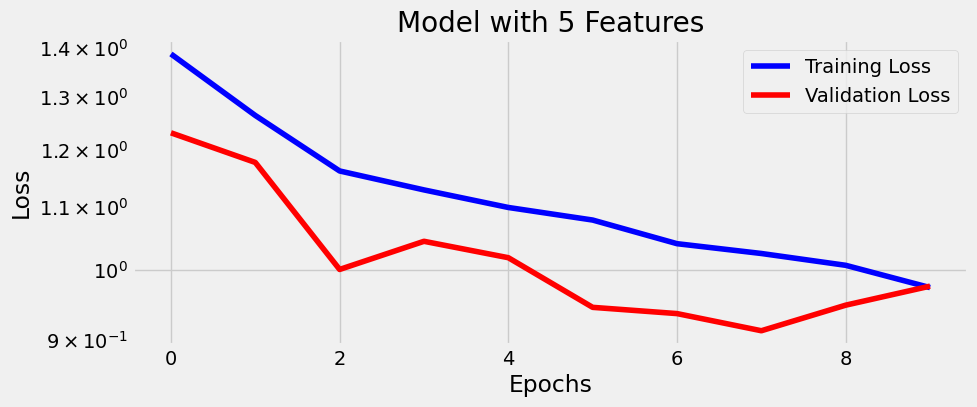

In [24]:
fig = arch_cnn2.plot_losses()
plt.title('Model with 5 Features')

### Accuracy

In [25]:
arch_cnn2.loader_apply(val_loader,
                           arch_cnn2.correct)

tensor([[17, 26],
        [14, 26],
        [ 9, 26],
        [21, 26],
        [16, 26]])

In [26]:
arch_cnn2.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([ 77, 130])

In [27]:
(lambda x: x[0].item() / x[1].item())(arch_cnn2.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.5923076923076923

### Visualizing Filters

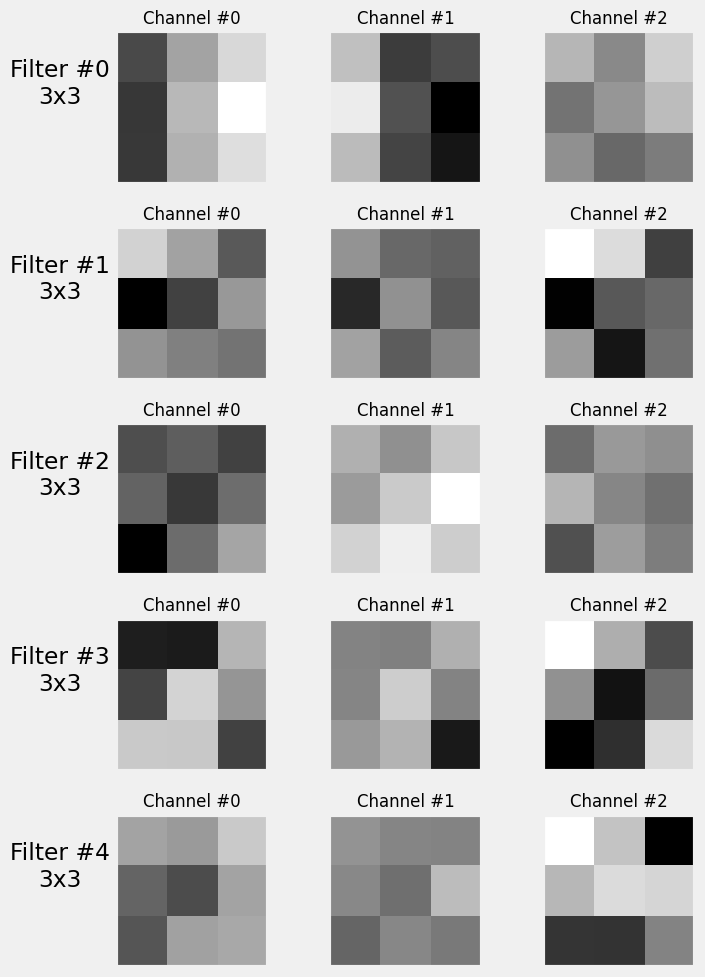

In [28]:
fig = arch_cnn2.visualize_filters('conv1')

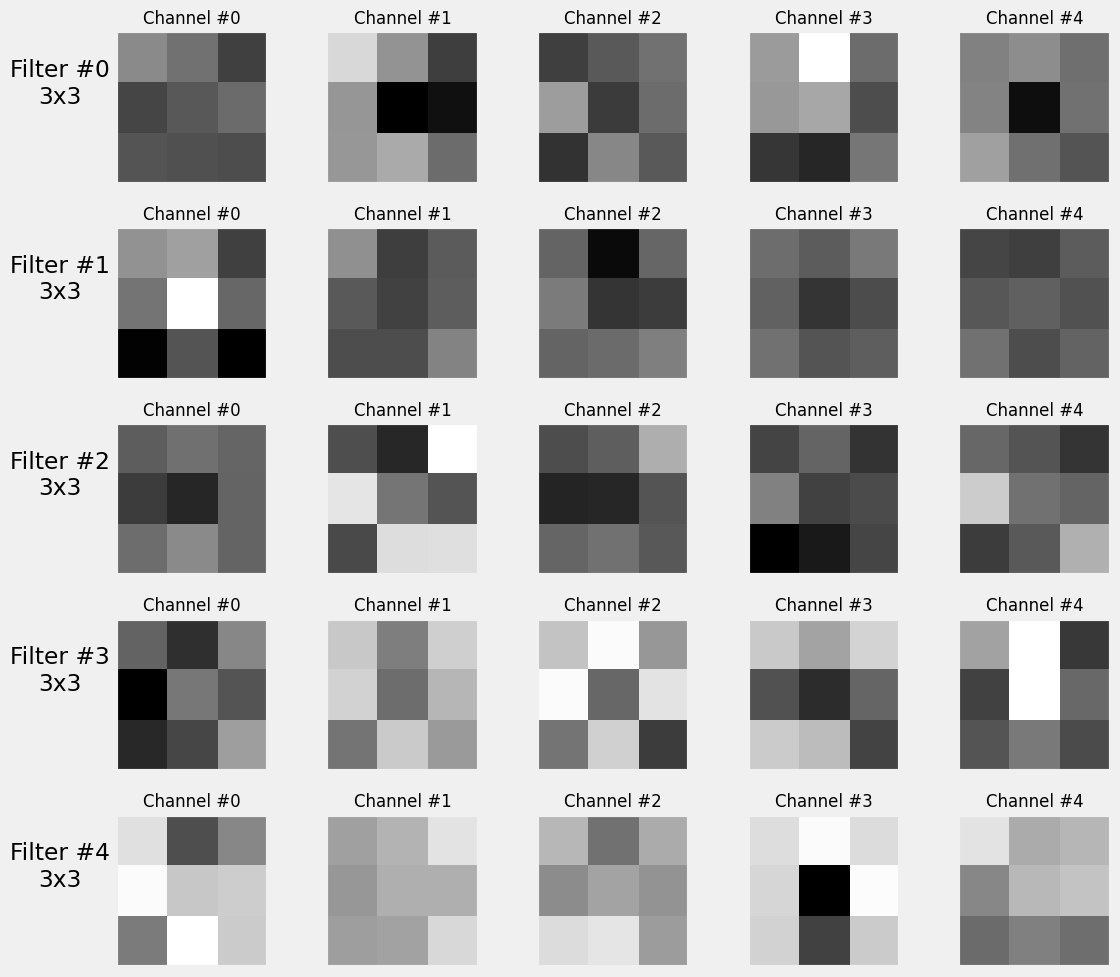

In [29]:
fig = arch_cnn2.visualize_filters('conv2')

### Confusion Matrix

In [30]:
def get_all_preds_and_labels(model, loader, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()  # modo avaliação

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            yhat = model(x)
            _, predicted = torch.max(yhat, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return all_preds, all_labels

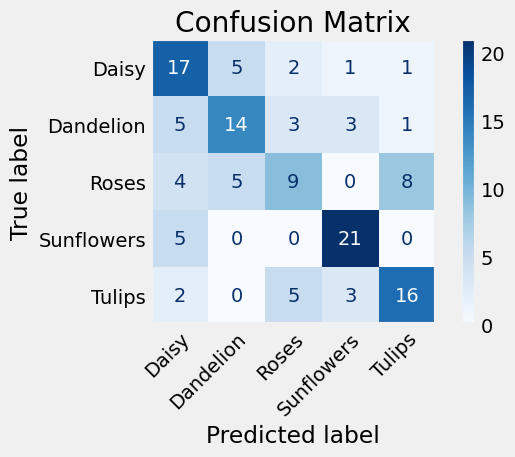

In [31]:
# Usa seu modelo treinado (arch_cnn2.model) e val_loader
all_preds, all_labels = get_all_preds_and_labels(arch_cnn2.model, val_loader, device=arch_cnn2.device)

# Agora plota a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


##Hooks

In [32]:
featurizer_layers = ['conv1',  'conv2', ]
classifier_layers = ['fc1', 'fc2']

arch_cnn2.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = arch_cnn2.predict(images_batch)
predicted = np.argmax(logits, 1)

arch_cnn2.remove_hooks()

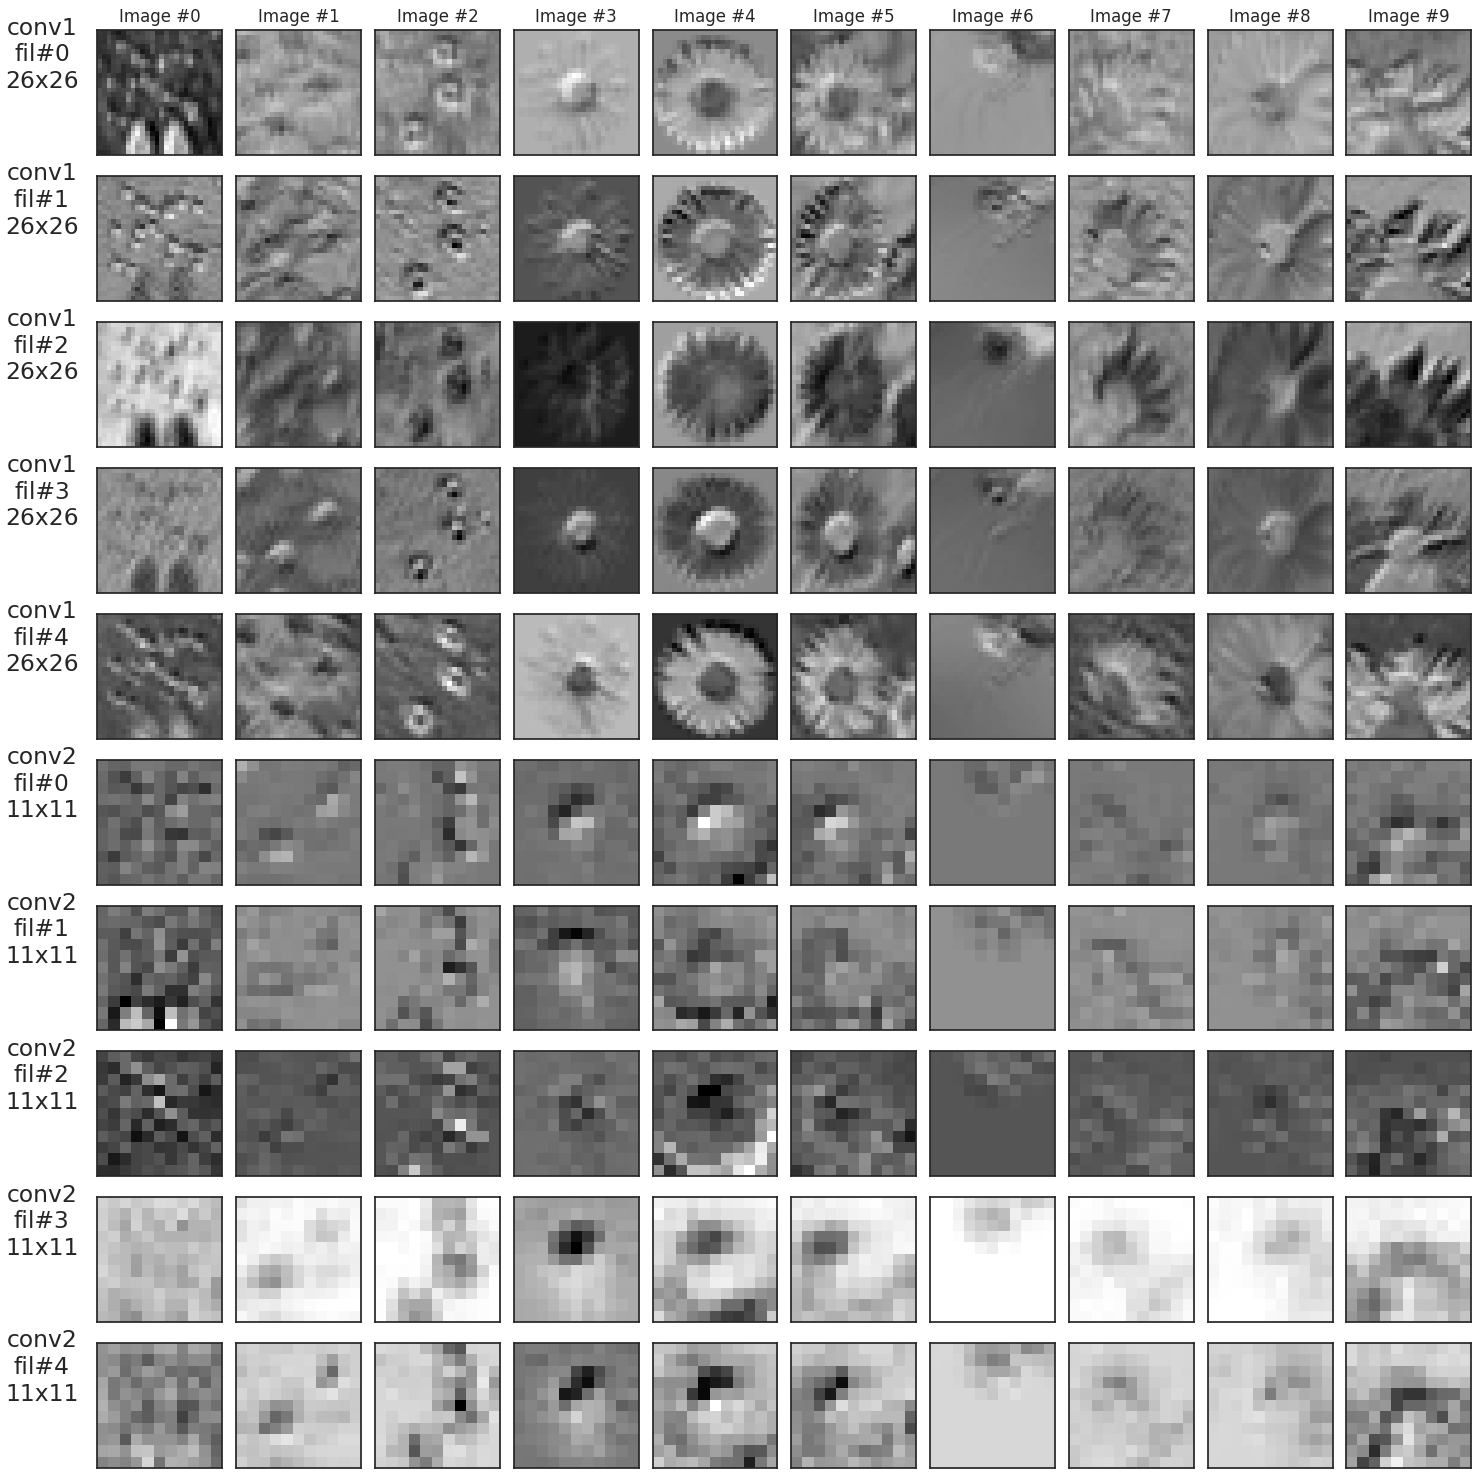

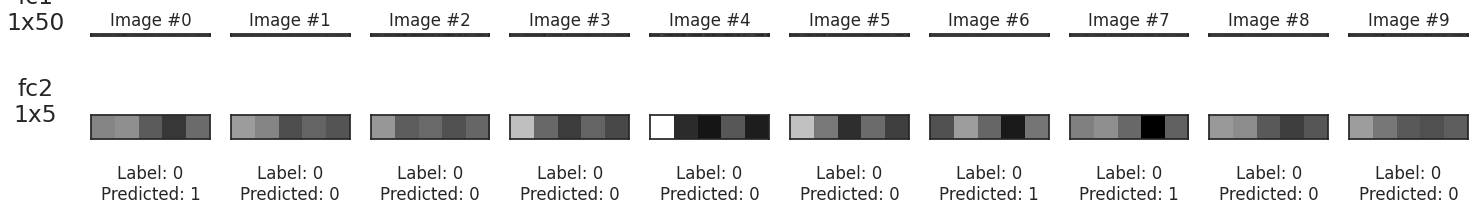

In [33]:
with plt.style.context('seaborn-v0_8-white'):
    fig_maps1 = arch_cnn2.visualize_outputs(featurizer_layers)
    fig_maps2 = arch_cnn2.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)